# Stock Price Prediction using Stacked LSTM Model

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
# fix random seed for reproducibility
np.random.seed(7)

In [2]:
#Import dataset
df = pd.read_csv("big_five_stocks.csv")
df["Unnamed: 0"] = pd.to_datetime(df["Unnamed: 0"])
df["year"] = df["Unnamed: 0"].dt.year
df["month"] = df["Unnamed: 0"].dt.month
df = df.rename({"Unnamed: 0" : "date"}, axis=1, inplace=False)

# get apple stock data
apple = df[df.name == 'AAPL'].drop("name", axis=1)
apple = apple.reset_index()['close']

# scale data
sc = MinMaxScaler(feature_range = (0, 1))
apple = sc.fit_transform(np.array(apple).reshape(-1,1))
apple

array([[0.00133696],
       [0.0012507 ],
       [0.00107819],
       ...,
       [0.91620304],
       [0.91542675],
       [0.87307543]])

In [3]:
# train-test split
training_size= int(len(apple)*0.65)
test_size = len(apple)-training_size
train_data, test_data = apple[0:training_size,:],apple[training_size:len(apple),:1]
print(train_data)

[[0.00133696]
 [0.0012507 ]
 [0.00107819]
 ...
 [0.04485272]
 [0.04368827]
 [0.04351576]]


In [4]:
# create for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX),np.array(dataY)

In [5]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [7]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
98/98 [==============================] - 35s 359ms/step - loss: 2.3958e-05 - val_loss: 0.0103
Epoch 2/100
98/98 [==============================] - 30s 303ms/step - loss: 9.6023e-07 - val_loss: 0.0062
Epoch 3/100
98/98 [==============================] - 30s 307ms/step - loss: 8.8986e-07 - val_loss: 0.0055
Epoch 4/100
98/98 [==============================] - 31s 316ms/step - loss: 8.8787e-07 - val_loss: 0.0025
Epoch 5/100
98/98 [==============================] - 31s 317ms/step - loss: 9.2132e-07 - val_loss: 0.0036
Epoch 6/100
98/98 [==============================] - 31s 315ms/step - loss: 7.4002e-07 - val_loss: 0.0029
Epoch 7/100
98/98 [==============================] - 31s 314ms/step - loss: 8.2411e-07 - val_loss: 0.0024
Epoch 8/100
98/98 [==============================] - 29s 291ms/step - loss: 7.3425e-07 - val_loss: 0.0029
Epoch 9/100
98/98 [==============================] - 28s 289ms/step - loss: 6.8539e-07 - val_loss: 0.0015
Epoch 10/100
98/98 [==========================

In [15]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
# performance
mse = mean_squared_error(y_test, test_predict)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test, test_predict)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print('RMSE: '+str(rmse))

MSE: 0.00047450504282199856
MAE: 0.011271241346924544
RMSE: 0.02178313666169311


In [19]:
train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

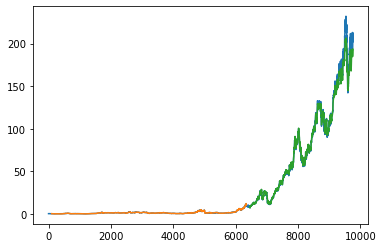

In [20]:
look_back=100
trainPredictPlot = np.empty_like(apple)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(apple)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(apple)-1, :] = test_predict
# plot baseline and predictions
plt.plot(sc.inverse_transform(apple))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()